# Multi-Label Classification Experiment

This notebook evaluates the performance of **Node2Vec**, **GraphSAGE**, and **GAT** models on multi-label classification tasks using three datasets: **PPI**, **Wikipedia**, and **BlogCatalog**. The models are assessed using the **F1 Score** metric. The goal is to understand how different graph embedding techniques perform on networks with multiple labels per node.

## Import Libraries

In [1]:
import scipy.io
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from node2vec import Node2Vec
from scipy.sparse import save_npz, load_npz

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATConv

device = torch.device('cpu')
print("CUDA Available:", torch.cuda.is_available())
print("MPS Available:", torch.backends.mps.is_available())
print("Device:", device)

PYTORCH_ENABLE_MPS_FALLBACK = 1

CUDA Available: False
MPS Available: True
Device: cpu


## Data Loading & Preprocessing
### Helper Functions for Loading Data

In [2]:
def load_mat_data(file_path, key):
    """Load .mat file and extract adjacency matrix"""
    data = scipy.io.loadmat(file_path)
    if key in data:
        return data[key]
    else:
        raise KeyError(f"Key '{key}' not found in .mat file")

def load_csv_data(edges_file, group_edges_file):
    """Load edge list and group memberships for BlogCatalog dataset"""
    edges = pd.read_csv(edges_file, header=None, names=['source', 'target'])
    group_edges = pd.read_csv(group_edges_file, header=None, names=['node_id', 'group_id'])
    return edges, group_edges

### Graph Creation and Label Preparation

In [3]:
def create_graph_from_edges(edges):
    """Create NetworkX graph from edge list."""
    graph = nx.Graph()
    graph.add_edges_from(edges.values)
    return graph

def prepare_labels(group_edges, num_nodes, num_groups):
    """Create a multi-label matrix for nodes."""
    labels = np.zeros((num_nodes, num_groups))
    for _, row in group_edges.iterrows():
        node_idx = row['node_id'] - 1  # Convert to zero-based index
        group_idx = row['group_id'] - 1
        labels[node_idx, group_idx] = 1
    return labels

### Save Processed Data

In [4]:
def save_data(adj_matrix, labels, adj_file, labels_file):
    """Save adjacency matrix and labels."""
    save_npz(adj_file, adj_matrix)
    np.save(labels_file, labels)
    print(f"Saved adjacency matrix to {adj_file}")
    print(f"Saved labels to {labels_file}")

## Dataset Processing
### File Paths

In [5]:
# PPI Dataset
ppi_file = './datasets/PPI/Homo_sapiens.mat'
processed_ppi_adj_file = './datasets/PPI/ppi_processed_adjacency_matrix.npz'
processed_ppi_labels_file = './datasets/PPI/ppi_processed_labels.npy'

# Wikipedia Dataset
wikipedia_file = './datasets/Wikipedia/POS.mat'
processed_wikipedia_adj_file = './datasets/Wikipedia/wikipedia_processed_adjacency_matrix.npz'
processed_wikipedia_labels_file = './datasets/Wikipedia/wikipedia_processed_labels.npy'

# BlogCatalog Dataset
edges_file = './datasets/BlogCatalog/data/edges.csv'
group_edges_file = './datasets/BlogCatalog/data/group-edges.csv'
processed_blogcatalog_adj_file = './datasets/BlogCatalog/data/blogcatalog_processed_adjacency_matrix.npz'
processed_blogcatalog_labels_file = './datasets/BlogCatalog/data/blogcatalog_processed_labels.npy'

### Process and Save Datasets

In [6]:
# PPI Dataset
print("Processing PPI dataset...")
adj_matrix_ppi = load_mat_data(ppi_file, 'network')
labels_ppi = load_mat_data(ppi_file, 'group').toarray()
save_data(adj_matrix_ppi, labels_ppi, processed_ppi_adj_file, processed_ppi_labels_file)

# Wikipedia Dataset
print("Processing Wikipedia dataset...")
adj_matrix_wikipedia = load_mat_data(wikipedia_file, 'network')
labels_wikipedia = load_mat_data(wikipedia_file, 'group').toarray()
save_data(adj_matrix_wikipedia, labels_wikipedia, processed_wikipedia_adj_file, processed_wikipedia_labels_file)

# BlogCatalog Dataset
print("Processing BlogCatalog dataset...")
edges, group_edges = load_csv_data(edges_file, group_edges_file)
g_blogcatalog = create_graph_from_edges(edges)
g_blogcatalog.remove_edges_from(nx.selfloop_edges(g_blogcatalog))
largest_cc = max(nx.connected_components(g_blogcatalog), key=len)
g_blogcatalog = g_blogcatalog.subgraph(largest_cc).copy()
adj_matrix_blogcatalog = nx.to_scipy_sparse_array(g_blogcatalog, format='csr')
num_nodes_blogcatalog = g_blogcatalog.number_of_nodes()
num_groups_blogcatalog = group_edges['group_id'].max()
labels_blogcatalog = prepare_labels(group_edges, num_nodes_blogcatalog, num_groups_blogcatalog)
save_data(adj_matrix_blogcatalog, labels_blogcatalog, processed_blogcatalog_adj_file, processed_blogcatalog_labels_file)

Processing PPI dataset...
Saved adjacency matrix to ./datasets/PPI/ppi_processed_adjacency_matrix.npz
Saved labels to ./datasets/PPI/ppi_processed_labels.npy
Processing Wikipedia dataset...
Saved adjacency matrix to ./datasets/Wikipedia/wikipedia_processed_adjacency_matrix.npz
Saved labels to ./datasets/Wikipedia/wikipedia_processed_labels.npy
Processing BlogCatalog dataset...
Saved adjacency matrix to ./datasets/BlogCatalog/data/blogcatalog_processed_adjacency_matrix.npz
Saved labels to ./datasets/BlogCatalog/data/blogcatalog_processed_labels.npy


## Model Training and Evaluation
### Node2Vec Model

In [7]:
def generate_node2vec_embeddings(graph, dimensions=128, walk_length=80, num_walks=10, workers=4):
    """Generate Node2Vec embeddings."""
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model.wv.vectors

### Train and Evaluate Classifier

In [8]:
def load_graph_and_labels(adj_file, labels_file):
    """Load a graph and corresponding labels from saved files."""
    adj_matrix = load_npz(adj_file)
    labels = np.load(labels_file)
    graph = nx.Graph(adj_matrix)
    return graph, labels

def train_classifier(X, y, test_size=0.3):
    """Train a logistic regression classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test

def evaluate_classifier(clf, X_test, y_test):
    """Evaluate the classifier and return the F1 score."""
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="weighted")
    return f1

def process_and_evaluate_node2vec(dataset_name, adj_file, labels_file):
    """Process a dataset with Node2Vec, train, and evaluate a classifier."""
    print(f"Processing {dataset_name} dataset with Node2Vec...")
    
    # Load the graph and labels
    graph, labels = load_graph_and_labels(adj_file, labels_file)
    
    # Generate Node2Vec embeddings
    embeddings = generate_node2vec_embeddings(graph, walk_length=20, num_walks=5, workers=5)
    
    # Convert multi-label matrix to single-class labels (argmax for simplicity)
    y = labels.argmax(axis=1)
    
    # Train and evaluate classifier
    clf, X_test, y_test = train_classifier(embeddings, y)
    f1 = evaluate_classifier(clf, X_test, y_test)
    
    print(f"{dataset_name} F1 Score (Node2Vec): {f1:.4f}")
    return f1

### Visualization Function

In [9]:
def visualize_results2(results):
    """Visualize F1 scores across datasets and algorithms with enhanced styling."""
    datasets = list(results.keys())
    algorithms = list(results[datasets[0]].keys())
    scores = np.array([[results[dataset][alg] for alg in algorithms] for dataset in datasets])
    x = np.arange(len(datasets))
    width = 0.25
    colors = ['#6C5B7B', '#C06C84', '#355C7D']

    plt.figure(figsize=(12, 7))
    plt.style.use('ggplot')
    for i, (alg, color) in enumerate(zip(algorithms, colors)):
        plt.bar(x + i * width, scores[:, i], width, label=alg, color=color, edgecolor='black', alpha=0.85)
        for j, score in enumerate(scores[:, i]):
            plt.text(x[j] + i * width, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Comparative Analysis of F1 Scores for Multi-Label Classification Models', fontsize=18, fontweight='bold')
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xticks(x + width, datasets, fontsize=12)
    plt.legend(title='Model', fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

## GNN Models: GraphSAGE and GAT
### Graph Data Loading and Preparation for PyTorch Geometric

In [10]:
def create_pyg_data(adj_file, labels_file):
    """Create PyTorch Geometric data object with train-test split."""
    adj_matrix = load_npz(adj_file)
    edge_index, _ = from_scipy_sparse_matrix(adj_matrix)
    labels = np.load(labels_file)
    y = labels.argmax(axis=1)

    # Normalize labels to ensure sequential values starting from 0
    unique_labels = np.unique(y)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_map[label] for label in y], dtype=np.int64)

    x = torch.eye(labels.shape[0]).to(device)  # Identity matrix as features
    data = Data(x=x, edge_index=edge_index.to(device), y=torch.tensor(y, dtype=torch.long).to(device))

    # Split indices for train and test
    num_nodes = data.x.size(0)
    indices = np.arange(num_nodes)
    train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
    data.train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    data.test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    return data

### GNN Model Definition

In [11]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, conv_layer, **kwargs):
        super(GNN, self).__init__()
        self.conv1 = conv_layer(input_dim, hidden_dim, **kwargs)
        self.conv2 = conv_layer(hidden_dim, output_dim, **kwargs)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

### Train and Evaluate GNN Model

In [12]:
def train_gnn_model(model, data, epochs=200, lr=0.01):
    """Train a GNN model using only the training set."""
    model = model.to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    return model

def evaluate_gnn_model(model, data):
    """Evaluate a trained GNN model using only the test set."""
    model = model.to(device)
    data = data.to(device)

    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        y_pred = logits[data.test_mask].argmax(dim=1).cpu().numpy()
        y_true = data.y[data.test_mask].cpu().numpy()
        f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

### Process and Evaluate GNN Models

In [13]:
def process_and_evaluate_gnn(dataset_name, adj_file, labels_file, conv_layer, **model_kwargs):
    """Process a dataset, train, and evaluate a GNN model."""
    print(f"Processing {dataset_name} dataset with {conv_layer.__name__}...")
    data = create_pyg_data(adj_file, labels_file)

    input_dim = data.x.size(1)
    output_dim = len(data.y.unique())
    model = GNN(input_dim, 32, output_dim, conv_layer, **model_kwargs)

    model = train_gnn_model(model, data)
    f1 = evaluate_gnn_model(model, data)
    print(f"{dataset_name} F1 Score ({conv_layer.__name__}): {f1}")
    return f1

## Run Experiments
### Initialize Results Dictionary

In [14]:
results = {"PPI": {}, "Wikipedia": {}, "BlogCatalog": {}}

### Run Node2Vec Experiment

In [15]:
# Node2Vec
for dataset_name, (adj_file, labels_file) in zip(
    ["PPI", "Wikipedia", "BlogCatalog"],
    [
        (processed_ppi_adj_file, processed_ppi_labels_file),
        (processed_wikipedia_adj_file, processed_wikipedia_labels_file),
        (processed_blogcatalog_adj_file, processed_blogcatalog_labels_file),
    ]
):
    results[dataset_name]["Node2Vec"] = process_and_evaluate_node2vec(
        dataset_name, adj_file, labels_file
    )


Processing PPI dataset with Node2Vec...


Computing transition probabilities:   0%|          | 0/3890 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


PPI F1 Score (Node2Vec): 0.0304
Processing Wikipedia dataset with Node2Vec...


Computing transition probabilities:   0%|          | 0/4777 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Wikipedia F1 Score (Node2Vec): 0.3194
Processing BlogCatalog dataset with Node2Vec...


Computing transition probabilities:   0%|          | 0/10312 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]


BlogCatalog F1 Score (Node2Vec): 0.0478


### Run GraphSAGE Experiment

In [16]:
# GraphSAGE
for dataset_name, (adj_file, labels_file) in zip(
    ["PPI", "Wikipedia", "BlogCatalog"],
    [(processed_ppi_adj_file, processed_ppi_labels_file), (processed_wikipedia_adj_file, processed_wikipedia_labels_file), (processed_blogcatalog_adj_file, processed_blogcatalog_labels_file)]
):
    results[dataset_name]["GraphSAGE"] = process_and_evaluate_gnn(
        dataset_name, adj_file, labels_file, SAGEConv
    )

Processing PPI dataset with SAGEConv...
PPI F1 Score (SAGEConv): 0.08891910444146633
Processing Wikipedia dataset with SAGEConv...
Wikipedia F1 Score (SAGEConv): 0.35868950284361895
Processing BlogCatalog dataset with SAGEConv...
BlogCatalog F1 Score (SAGEConv): 0.05669232801463675


### Run GAT Experiment

In [17]:
# GAT
for dataset_name, (adj_file, labels_file) in zip(
    ["PPI", "Wikipedia", "BlogCatalog"],
    [(processed_ppi_adj_file, processed_ppi_labels_file), (processed_wikipedia_adj_file, processed_wikipedia_labels_file), (processed_blogcatalog_adj_file, processed_blogcatalog_labels_file)]
):
    results[dataset_name]["GAT"] = process_and_evaluate_gnn(
        dataset_name, adj_file, labels_file, GATConv
    )

Processing PPI dataset with GATConv...
PPI F1 Score (GATConv): 0.11098448825194399
Processing Wikipedia dataset with GATConv...
Wikipedia F1 Score (GATConv): 0.3128120555637768
Processing BlogCatalog dataset with GATConv...
BlogCatalog F1 Score (GATConv): 0.05716237321279703


In [18]:
# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame([
    {"Dataset": dataset, "Model": model, "F1_Score": score}
    for dataset, models in results.items()
    for model, score in models.items()
])

results_df.to_csv("results_MLClassification.csv", index=False)
print("Results saved to results_MLClassification.csv")

Results saved to results_MLClassification.csv


In [19]:
# Load results from CSV
loaded_results_df = pd.read_csv("results_MLClassification.csv")

# Convert DataFrame back to the original nested dictionary structure
loaded_results = {}
for _, row in loaded_results_df.iterrows():
    dataset = row["Dataset"]
    model = row["Model"]
    score = row["F1_Score"]
    if dataset not in loaded_results:
        loaded_results[dataset] = {}
    loaded_results[dataset][model] = score

print("Results loaded from results_MLClassification.csv")

Results loaded from results_MLClassification.csv


In [20]:
loaded_results_df

,Dataset,Model,F1_Score
0,PPI,Node2Vec,0.030363
1,PPI,GraphSAGE,0.088919
2,PPI,GAT,0.110984
3,Wikipedia,Node2Vec,0.319371
4,Wikipedia,GraphSAGE,0.358690
5,Wikipedia,GAT,0.312812
6,BlogCatalog,Node2Vec,0.047800
7,BlogCatalog,GraphSAGE,0.056692
8,BlogCatalog,GAT,0.057162


## Visualize Results
### Plot the Results

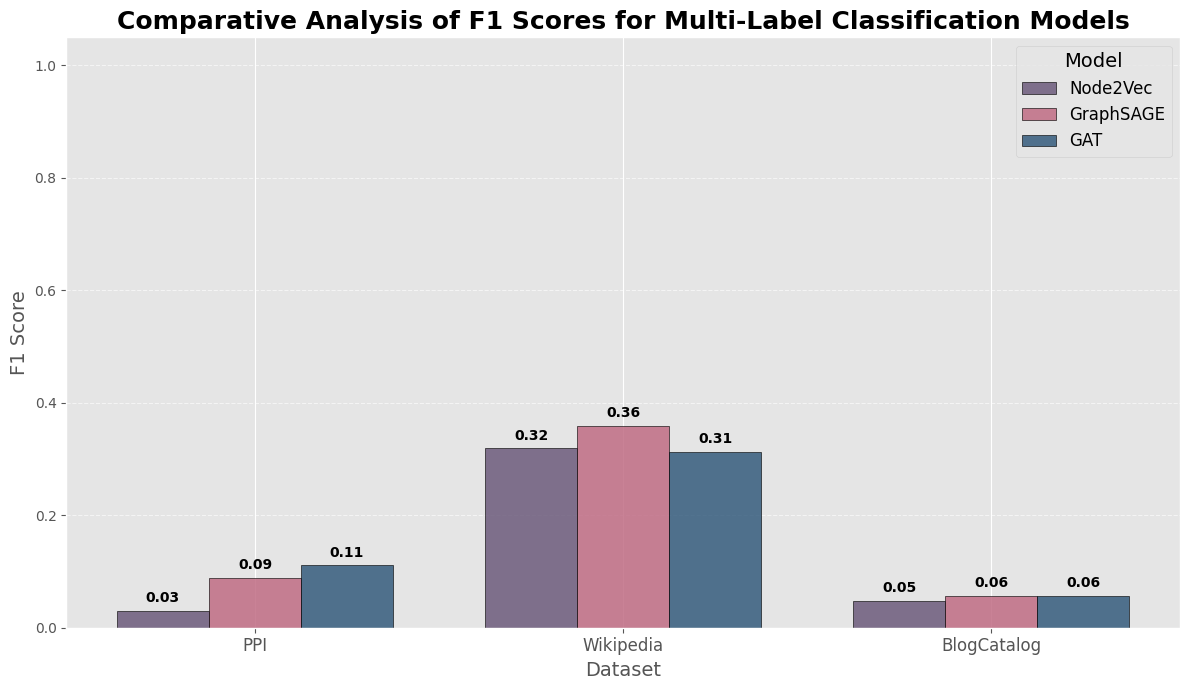

In [21]:
def visualize_results2(results):
    """Visualize F1 scores across datasets and algorithms with enhanced styling."""
    datasets = list(results.keys())
    algorithms = list(results[datasets[0]].keys())
    scores = np.array([[results[dataset][alg] for alg in algorithms] for dataset in datasets])
    x = np.arange(len(datasets))
    width = 0.25
    colors = ['#6C5B7B', '#C06C84', '#355C7D']

    plt.figure(figsize=(12, 7))
    plt.style.use('ggplot')
    for i, (alg, color) in enumerate(zip(algorithms, colors)):
        plt.bar(x + i * width, scores[:, i], width, label=alg, color=color, edgecolor='black', alpha=0.85)
        for j, score in enumerate(scores[:, i]):
            plt.text(x[j] + i * width, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Comparative Analysis of F1 Scores for Multi-Label Classification Models', fontsize=18, fontweight='bold')
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xticks(x + width, datasets, fontsize=12)
    plt.legend(title='Model', fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

visualize_results2(loaded_results)

## 📊 Conclusion

In this experiment, we evaluated **Node2Vec**, **GraphSAGE**, and **GAT** on the **PPI**, **Wikipedia**, and **BlogCatalog** datasets for multi-label classification. Here are the key insights:

- **Wikipedia Dataset**:
  - This dataset produced the best results for all models.
  - **GraphSAGE** led with an F1 score of **0.36**, followed by **Node2Vec** (**0.32**) and **GAT** (**0.31**).
  - The Wikipedia graph structure appears ideal for these models to capture meaningful relationships.

- **PPI Dataset**:
  - The models struggled with the PPI dataset, showing low F1 scores.
  - **GAT** performed best with **0.11**, while **GraphSAGE** and **Node2Vec** scored **0.09** and **0.03**, respectively.
  - The complexity of biological networks makes learning clear patterns challenging.

- **BlogCatalog Dataset**:
  - All models had difficulty with BlogCatalog, achieving low and similar scores.
  - **GraphSAGE** and **GAT** both scored **0.06**, slightly better than **Node2Vec** at **0.05**.
  - This suggests that sparsity or community structure complicates classification.

### 🔍 Insights

- **GraphSAGE** performed consistently well, especially on the Wikipedia dataset.
- **GAT** showed promise on the PPI dataset, benefiting from its attention mechanism.
- **Node2Vec** served as a baseline but fell behind GNN models, highlighting the advantages of deeper graph structure exploitation.

### 🚀 Looking Ahead

- **Hyperparameter Tuning**: Adjusting learning rates or embedding dimensions could improve results.
- **Richer Features**: Incorporating detailed node features may enhance learning.
- **Data Analysis**: Investigating dataset structures like node degrees and clustering may provide insights for boosting performance.

These results establish a solid foundation for enhancing multi-label classification across different network types.